Installation
To use tikzmagic simply run:  pip install git+git://github.com/robjstan/tikzmagic.git

In [1]:
import tikzmagic

# Conway (working title) : Generic Seismic Application using Devito

Following the redesign and rework of code inside Devito, we wish to extend a good structure to application code as well. The objectives here are two-fold: 
* Provide a set of seismic abstractions that help set up a problem quickly 
  * This ensures that an example can be set up in as few lines as possible
* Provide a set of "Execution Engine" abstractions that the seismic code above uses.
  * This ensure that the same code set up for demo inside an IPython notebook can run at scale on Amazon or on a large cluster
  
## Seismic Abstractions
In terms of seismic, we need: 
* Seismic Data Reader / Writer
* Container objects for Shot Data - `Source` and `Receiver` can be thin abstractions over the existing `SourceLike` class in Devito. These should be sufficient for holding the data for a shot. 
* An encapsulation for the actual physics - This is where the equation will live. This is the only object that changes to switch from Acoustic to TTI, for example. (Please suggest a name)
* Operator builders (Propagators) - These will be instances of Devito's `Operator`/`StencilKernel` class. We will provide functions to build these given the "Physics" object from above. There could be one builder each for `Forward`/`Backward`/`Gradient`/`Born`

## Execution Engine
I expect this to be a thin wrapper over ipyparallel to begin with, but with plans to extend support for Amazon AWS/dedicated clusters. Note that to support running over AWS/clusters it should be possible to add [Celery](http://www.celeryproject.org) or [RQ](http://python-rq.org) as a backend to this execution engine and the rest should be quite straightforward.
The Execution Engine has 3 basic components like any other similar engine:
* Controller
* Worker 
* Reducer

The assumption is that the communication between these happens via queues which will be handled internally by the execution engine. The engine needs to handle nodes dying out in the middle of a shot - just restart the entire shot when that happens. 

The flowchart below attempts to explain the planned information/logic flow:

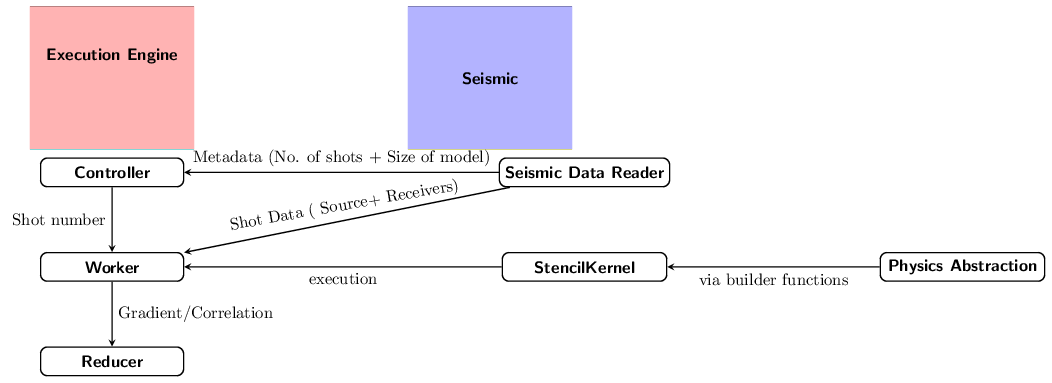

In [51]:
%%tikz -s 0.4 

%# Style definitions
\tikzstyle{line} = [draw, thick];
\tikzstyle{arrow} = [-stealth, line];
\tikzstyle{box} = [draw, thick, rectangle, rounded corners, font=\sffamily];

\node (controller) [box, minimum height=4ex, minimum width=20ex,font=\sffamily\bfseries] at (0, 6) {Controller};
\node (worker) [box, minimum height=4ex, minimum width=20ex,font=\sffamily\bfseries] at (0, 4) {Worker};
\node (reducer) [box, minimum height=4ex, minimum width=20ex,font=\sffamily\bfseries] at (0, 2) {Reducer};


\node (datareader) [box, minimum height=4ex, minimum width=23ex,font=\sffamily\bfseries] at (10, 6) {Seismic Data Reader};
\node (stencilkernel) [box, minimum height=4ex, minimum width=23ex,font=\sffamily\bfseries] at (10, 4) {StencilKernel};
\node (abstractions) [box, minimum height=4ex, minimum width=23ex,font=\sffamily\bfseries] at (18, 4) {Physics Abstraction};

\node (execution) [minimum height=20ex, minimum width=23ex,font=\sffamily\bfseries, fill=red!30, text depth=1cm] at (0, 8) {Execution Engine};
\node (seismic) [minimum height=20ex, minimum width=23ex,font=\sffamily\bfseries, fill=blue!30] at (8, 8) {Seismic};


\draw[arrow] (datareader) -- node[anchor=south] {Metadata (No. of shots + Size of model)} (controller) ;
\draw[arrow] (controller) -- node[anchor=east] {Shot number} (worker) ;
\draw[arrow] (datareader) -- node[anchor=south, rotate=10] {Shot Data ( Source+ Receivers)} (worker) ;
\draw[arrow] (abstractions) -- node[anchor=north] {via builder functions} (stencilkernel) ;
\draw[arrow] (stencilkernel) -- node[anchor=north] {execution} (worker) ;
\draw[arrow] (worker) -- node[anchor=west] {Gradient/Correlation} (reducer) ;